# Reconstructing the Coffee Taster's Flavor Wheel

- Data Sources: [SCA](https://scanews.coffee/2016/01/19/reinventing-the-flavor-wheel-industry-collaborates-to-identify-coffee-flavor-attributes/), [Journal of Food Science](https://onlinelibrary.wiley.com/doi/full/10.1111/1750-3841.13555), [notbadcoffee.com](https://notbadcoffee.com/flavor-wheel-en/)

![caption](http://www.scanews.coffee/wp-content/uploads/2016/01/SCAA_FlavorWheel_Poster.01.18.15_Page_3-1024x510.jpg)

# Dependencies and constants

In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

# visual settings
FIGSIZE = (15,15)
DPI = 100
BGCOLOR = "#D1D2CC"

# parsed from: https://notbadcoffee.com/flavor-wheel-en/
COLOR_DATA_PATH = "flavor_wheel_colors_and_names.html"

# downloaded from: https://onlinelibrary.wiley.com/doi/full/10.1111/1750-3841.13555
DATA_ORDER_PATH = "flavor_wheel_data.csv"

# Build the data structure

## Assign colors to flavors

In [2]:
# parse the html with this information
soup = BeautifulSoup(open(COLOR_DATA_PATH), "html.parser")

# first, build a list of colors (in hex format)
flavor_colors = []
for result in soup.find_all("path"):
    s = result.attrs['style']
    s = s.replace('fill: rgb(', '').replace(');', '')
    rgb_tuple = tuple(map(int, s.split(', ')))
    hex_color = '#%02x%02x%02x' % (rgb_tuple)
    flavor_colors.append(hex_color)
    
# second, build a list of flavor names
flavor_names = []
for result in soup.find_all("tspan"):
    f = result.get_text()
    if f == 'Mapple syrup': f = 'Maple syrup'
    f = f.title()
    flavor_names.append(f)

# zip the two lists together
flavors_and_colors = dict(zip(flavor_names, flavor_colors))

## Determine flavor hierarchy

In [3]:
# load a table that represents the flavor wheel hierarchy
wheel_data = pd.read_csv(DATA_ORDER_PATH)

# forward fill NaN parent nodes
wheel_data['Node1'].fillna(method='ffill', inplace=True)
wheel_data['Node2'].fillna(method='ffill', inplace=True)

# fill empty outer nodes with 'none'
wheel_data['Node3'].fillna('none', inplace=True)

# remove asterisks from flavor names
wheel_data = wheel_data.applymap(lambda x: x.replace('*','') if isinstance(x, str) else x)

# convert all names to Title case
wheel_data = wheel_data.applymap(lambda x: x.title() if isinstance(x, str) else x)

wheel_data.head()

,Node1,Node2,Node3
0,Floral,Black Tea,None
1,Floral,Floral,Chamomile
2,Floral,Floral,Rose
3,Floral,Floral,Jasmine
4,Fruity,Berry,Blackberry


## Turn the data table into a tree
This [Stack Overflow post](https://stackoverflow.com/questions/43757965/convert-csv-to-json-tree-structure) was helpful in doing this

In [4]:
REPLACEMENTS = [
    {'Flavor': 'Green/Vegetative', 'Level': 1, 'Color': '#197A2F'},
    {'Flavor': 'Floral', 'Level': 1, 'Color': '#DA0D68'}
]

def resolve_duplicate(res):
    for r in REPLACEMENTS:
        if r['Flavor'] == res['Flavor'] and r['Level'] == res['Level']:
            res.update(r)
    return res

def build_leaf(flavor, leaf, level):
    try:
        color = flavors_and_colors[flavor.title()]
    except:
        color = 'none'
    res = {"Flavor": flavor, "Color": color, "Level": level}
    res = resolve_duplicate(res)
    if len(leaf.keys()) > 0:
        res["children"] = [
            build_leaf(k, v, level+1) 
            for k, v in leaf.items()
        ]
    return res

def ctree():
    return defaultdict(ctree)

tree = ctree()
for rid, row in wheel_data.iterrows():
    leaf = tree[row[0]]
    for child_id in range(1, len(row)):
        leaf = leaf[row[child_id]]

flavor_tree = []
for name, leaf in tree.items():
    flavor_tree.append(build_leaf(name, leaf, 1))
    
flavor_tree[0]    

{'Flavor': 'Floral',
 'Color': '#DA0D68',
 'Level': 1,
 'children': [{'Flavor': 'Black Tea',
   'Color': '#975e6d',
   'Level': 2,
   'children': [{'Flavor': 'None', 'Color': 'none', 'Level': 3}]},
  {'Flavor': 'Floral',
   'Color': '#e0719c',
   'Level': 2,
   'children': [{'Flavor': 'Chamomile', 'Color': '#f99e1b', 'Level': 3},
    {'Flavor': 'Rose', 'Color': '#ef5a78', 'Level': 3},
    {'Flavor': 'Jasmine', 'Color': '#f7f1bd', 'Level': 3}]}]}

## Traverse and create a flat version of the tree

In [5]:
def traverse(nodes):
    if nodes is not None:
        for node in nodes:
            yield node
            if 'children' in node:
                for child in traverse(node['children']):
                    yield child
                
flavor_list = list(traverse(flavor_tree))
flavor_list[0]

{'Flavor': 'Floral',
 'Color': '#DA0D68',
 'Level': 1,
 'children': [{'Flavor': 'Black Tea',
   'Color': '#975e6d',
   'Level': 2,
   'children': [{'Flavor': 'None', 'Color': 'none', 'Level': 3}]},
  {'Flavor': 'Floral',
   'Color': '#e0719c',
   'Level': 2,
   'children': [{'Flavor': 'Chamomile', 'Color': '#f99e1b', 'Level': 3},
    {'Flavor': 'Rose', 'Color': '#ef5a78', 'Level': 3},
    {'Flavor': 'Jasmine', 'Color': '#f7f1bd', 'Level': 3}]}]}

# Render the color wheel as a chart

In [6]:
# The width of the pie is a function of how many children each flavor has
def count_children(node):
    num_children = 0
    if 'children' in node.keys():
        for child in node['children']:
            num_children += count_children(child)
    else:
        return 1
    return num_children


def pie_chart_from_flavor_list(ax, list_of_flavors, radius=1, label_loc=.5):

    # get the variables we need to render the pie chart
    names  = [f['Flavor'] for f in list_of_flavors]
    colors = [f['Color'] for f in list_of_flavors]
    widths = [count_children(f) for f in list_of_flavors]
    
    # styling settings
    settings = dict(
        counterclock=False, 
        startangle=90, 
        rotatelabels=270,
        textprops={'color': 'None', 'fontname': 'Arial', 'fontsize': 10},
        wedgeprops={'linewidth': 1.5, 'edgecolor': BGCOLOR, 'alpha': 1}
    )
    
    # make the pie chart
    pie = ax.pie(
        widths, 
        labels=names, 
        colors=colors, 
        radius=radius, 
        labeldistance=label_loc, 
        **settings
    )

    # add the flavor names as annotations
    if label_loc > radius:
        labelcolors = colors
    else:
        labelcolors = ['White'] * len(colors)
    for i, label in enumerate(pie[1]):
        label.set_color(labelcolors[i])
        
    return ax

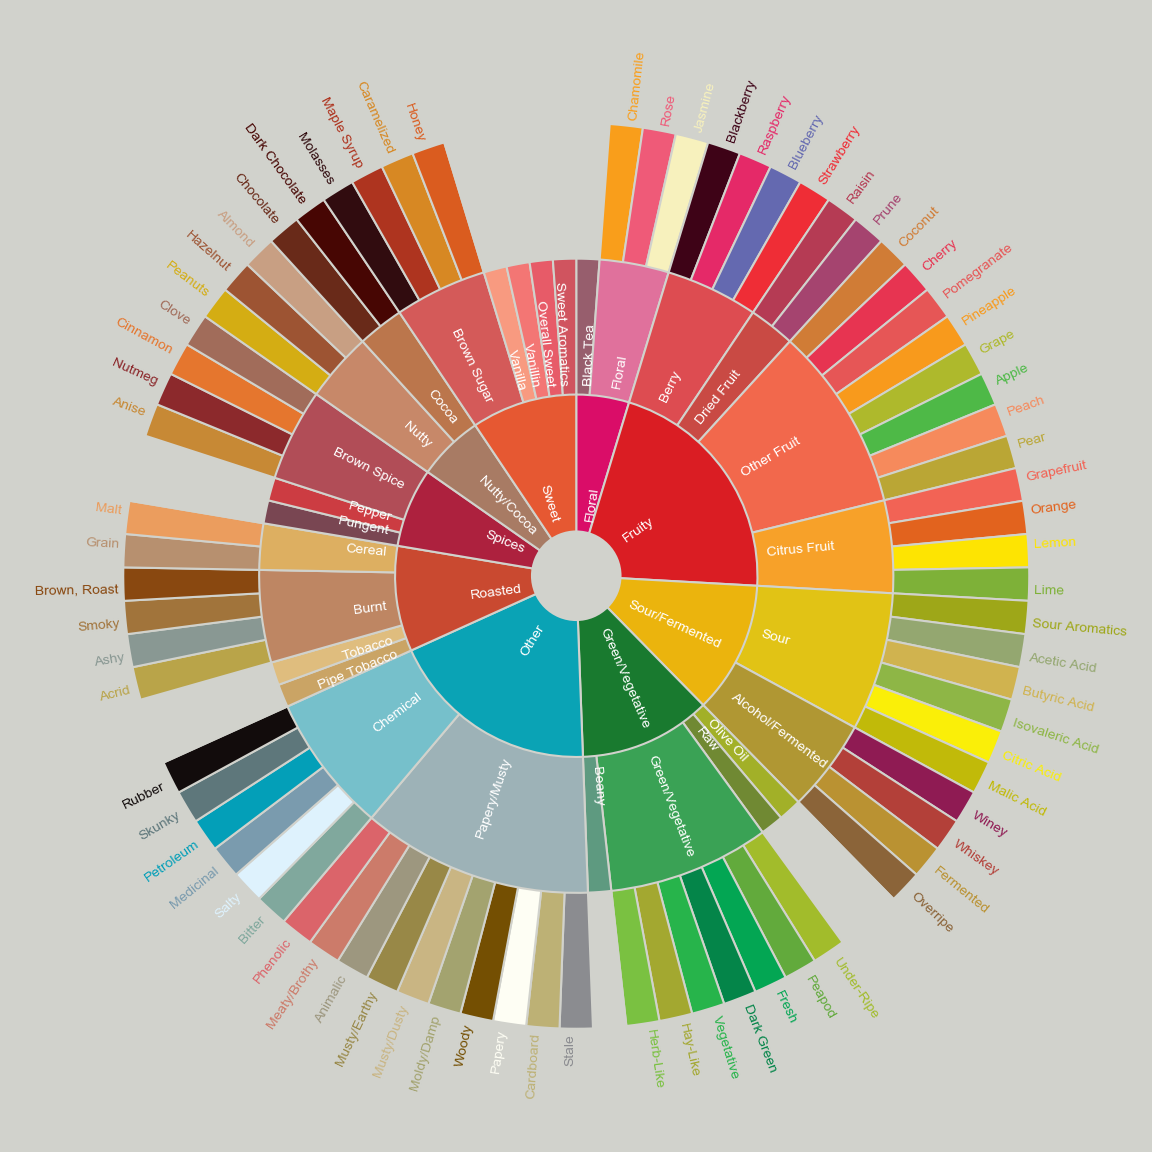

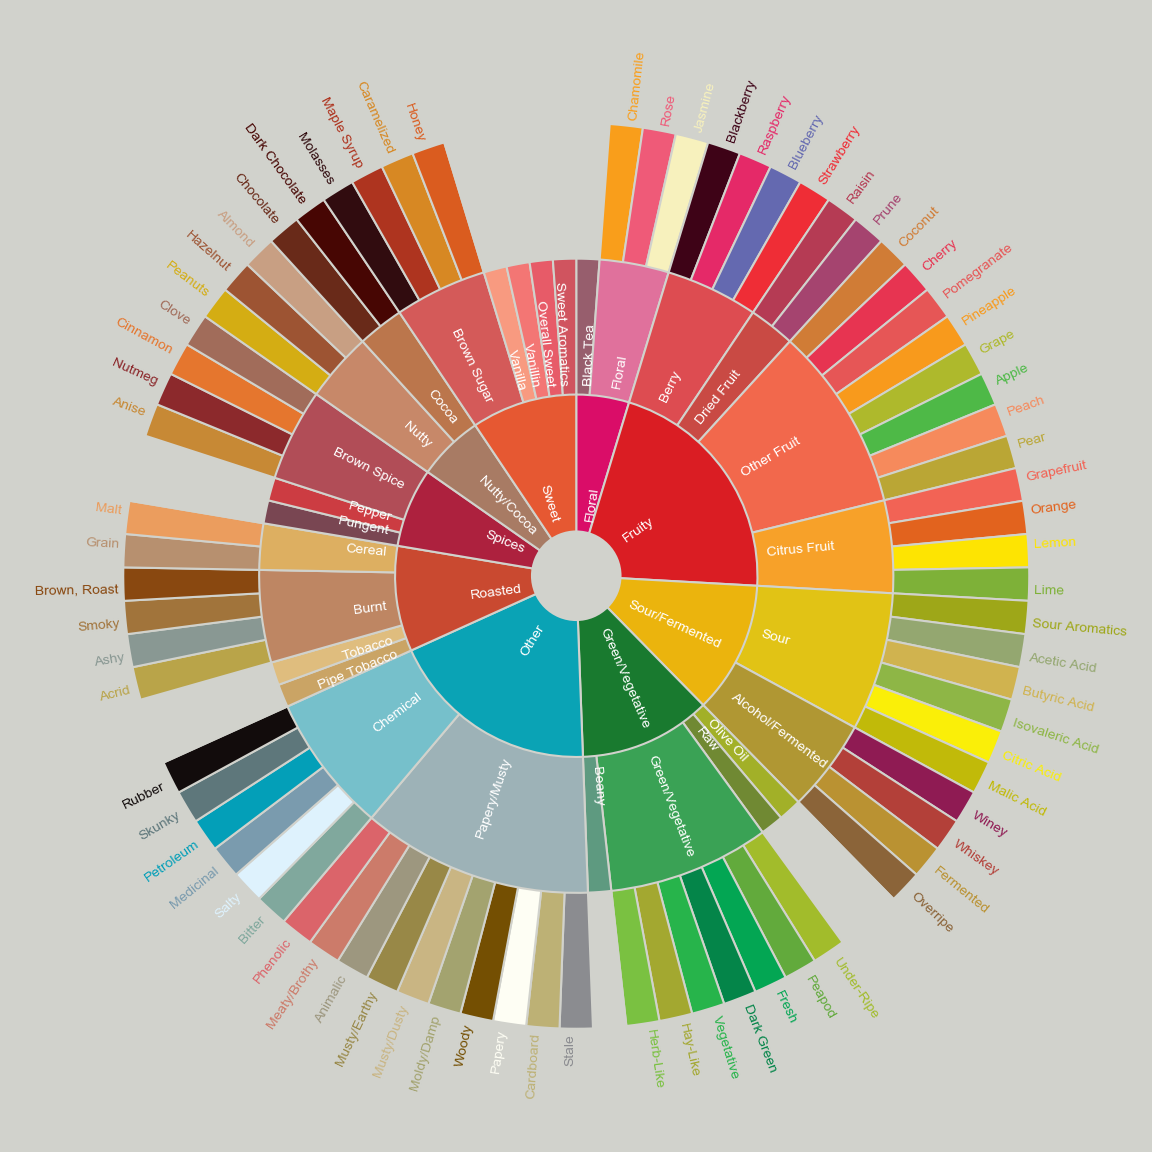

In [7]:
# initialize the plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI, facecolor=BGCOLOR)

# first, make the outer nodes of the pie
outer_flavors  = [f for f in flavor_list if f['Level'] == 3]
pie_chart_from_flavor_list(ax, outer_flavors, radius=1, label_loc=1.01)

# second, impose the middle nodes 
middle_flavors = [f for f in flavor_list if f['Level'] == 2]
pie_chart_from_flavor_list(ax, middle_flavors, radius=.7, label_loc=.6)

# third, impose the inner nodes
inner_flavors  = [f for f in flavor_list if f['Level'] == 1]
pie_chart_from_flavor_list(ax, inner_flavors, radius=.4, label_loc=.3)

# last, make a circle in the middle
ax.pie([1], radius=.1, colors=[BGCOLOR])

fig